# Predicting Delhi's Air Quality Index (AQI) with Multivariate Linear Regression
## An extension of the Delhi Air Quality Analysis project, this notebook applies multivariate linear regression to identify key environmental factors contributing to Delhi’s AQI levels. By modeling the relationship between pollutant concentrations and AQI, we aim to both explain and predict variations in air quality.
### Author: Jackson Fleege

In [525]:
# importing libraries that will be used in this analysis
import pandas as pd # for manipulation/analysis
import numpy as np # for histogram and correlation matrix
import matplotlib.pyplot as plt # plotting data
import seaborn as sns # formatting graphs/images
import statsmodels.api as sm # obtain extensive stat summary results

from matplotlib.patches import Patch # for legend
from sklearn.model_selection import train_test_split # for MLR training/testing
from pandas.core.common import random_state # for MLR model (testing)
from sklearn.linear_model import LinearRegression # MLR model

## Background

### What is Air Quality Index (AQI)?
The U.S. Air Quality Index (AQI) is EPA's tool for communicating about outdoor air quality and health. The AQI includes six color-coded categories, each corresponding to a range of index values. The higher the AQI value, the greater the level of air pollution and the greater the health concern. For example, an AQI value of 50 or below represents good air quality, while an AQI value over 300 represents hazardous air quality.

This information is sourced from: https://www.airnow.gov/. For more information: https://www.airnow.gov/aqi/aqi-basics/

### About the Dataset
This dataset contains daily records of air pollutant concentrations collected over time, including PM2.5, PM10, NO₂, SO₂, CO, and Ozone. It also logs the Air Quality Index (AQI), along with date (day, month, year) also includes number of holidays and weekday representation. It is ideal for developing models to predict AQI, study pollution patterns, and analyze the effects of temporal or holiday factors on air quality.

This dataset used for this project can publicly be accessed on Kaggle:
https://www.kaggle.com/datasets/kunshbhatia/delhi-air-quality-dataset


In [526]:
# importing and reading dataset to obtain general idea/statistics that will be worked with
df = pd.read_csv("final_dataset.csv")
df.describe()

,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,15.729637,6.522930,2022.501027,0.189596,4.000684,90.774538,218.219261,37.184921,20.104921,1.025832,36.338871,202.210815
std,8.803105,3.449884,1.118723,0.392116,2.001883,71.650579,129.297734,35.225327,16.543659,0.608305,18.951204,107.801076
min,1.000000,1.000000,2021.000000,0.000000,1.000000,0.050000,9.690000,2.160000,1.210000,0.270000,2.700000,19.000000
25%,8.000000,4.000000,2022.000000,0.000000,2.000000,41.280000,115.110000,17.280000,7.710000,0.610000,24.100000,108.000000
50%,16.000000,7.000000,2023.000000,0.000000,4.000000,72.060000,199.800000,30.490000,15.430000,0.850000,32.470000,189.000000
75%,23.000000,10.000000,2024.000000,0.000000,6.000000,118.500000,297.750000,45.010000,26.620000,1.240000,45.730000,284.000000
max,31.000000,12.000000,2024.000000,1.000000,7.000000,1000.000000,1000.000000,433.980000,113.400000,4.700000,115.870000,500.000000


### Procedure

The dataset used in this analysis spans five years (2021–2025) and includes measurements of various air pollutants in Delhi, including PM2.5, PM10, NO₂, SO₂, and CO. These values were recorded over time and will be used to assess air quality conditions across the city.

For the purposes of this study, we will focus on the pollutants that most directly contribute to the Air Quality Index (AQI), as determined by exploratory data analysis and correlation testing.

To accurately model AQI, we apply a multivariate linear regression approach using the most significant contributing variables. The goal is to predict AQI from known pollutant concentrations and evaluate how well each pollutant explains the variation in air quality over time.

To start, we will begin by establishing a distribution plot of the air quality index to understand the general pattern not easily shown by the numbers themselves:


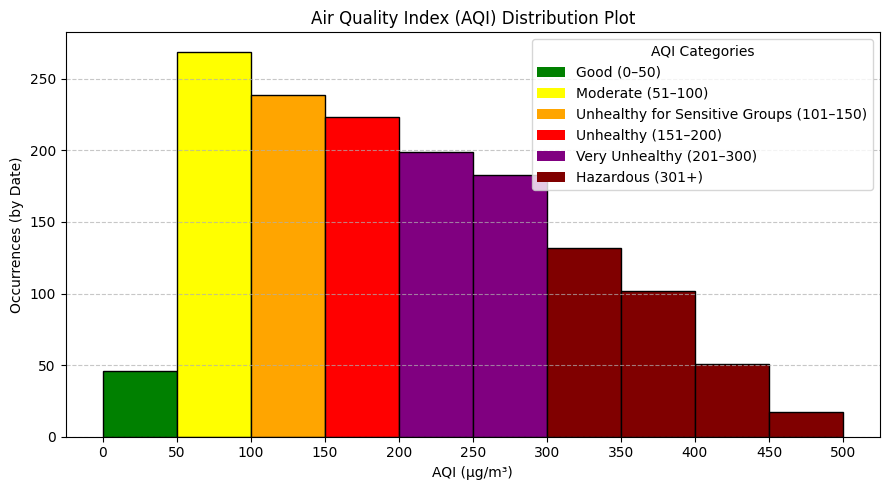

In [527]:
# creating a data distribution of the AQI over 5 year span
counts, bin_edges = np.histogram(df['AQI'], bins=np.arange(0, df['AQI'].max() + 50, 50))

# defining AQI color coding based off of airnow.gov (boundaries must match bins)
def get_aqi_color(value):
    if value < 50:
        return "green"
    elif value < 100:
        return "yellow"
    elif value < 150:
        return "orange"
    elif value < 200:
        return "red"
    elif value < 300:
        return "purple"
    else:
        return "maroon"

colors = [get_aqi_color(edge) for edge in bin_edges[:-1]]

# plotting colored bars
plt.figure(figsize=(9, 5))
plt.bar(bin_edges[:-1], counts, width=50, color=colors, align='edge', edgecolor='black')

# formatting the graph
plt.title('Air Quality Index (AQI) Distribution Plot')
plt.xlabel('AQI (µg/m³)')
plt.ylabel('Occurrences (by Date)')
plt.xticks(np.arange(0, df['AQI'].max() + 50, 50))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# legend
legend_elements = [
    Patch(facecolor='green', label='Good (0–50)'),
    Patch(facecolor='yellow', label='Moderate (51–100)'),
    Patch(facecolor='orange', label='Unhealthy for Sensitive Groups (101–150)'),
    Patch(facecolor='red', label='Unhealthy (151–200)'),
    Patch(facecolor='purple', label='Very Unhealthy (201–300)'),
    Patch(facecolor='maroon', label='Hazardous (301+)')
]
plt.legend(handles=legend_elements, title='AQI Categories', loc='upper right')

# print
plt.tight_layout()
plt.show()

After standardizing the AQI data according to EPA guidelines, we observe that fewer than 50 out of 1,461 total days fell within the “Good” air quality range (AQI ≤ 50). This indicates that healthy air conditions were exceptionally rare during the five-year observation period, prompting an investigation into the underlying causes of such consistently poor outcomes.

### Research Question
Although PM2.5, PM10, NO₂, SO₂, and CO are all known contributors to air pollution, which of these pollutants has the most direct and measurable impact on Delhi’s Air Quality Index?

## Conducting the Multiple Linear Regression Model
To identify the most significant causal factors influencing AQI, we begin by creating a correlation matrix. This allows us to visualize the relationships between each pollutant and AQI, as well as the interdependencies among the pollutants themselves and other variables such as holidays and ozone levels. To easily visualize these associations, we can create a heatmap to easily distinguish noticeable outcomes:

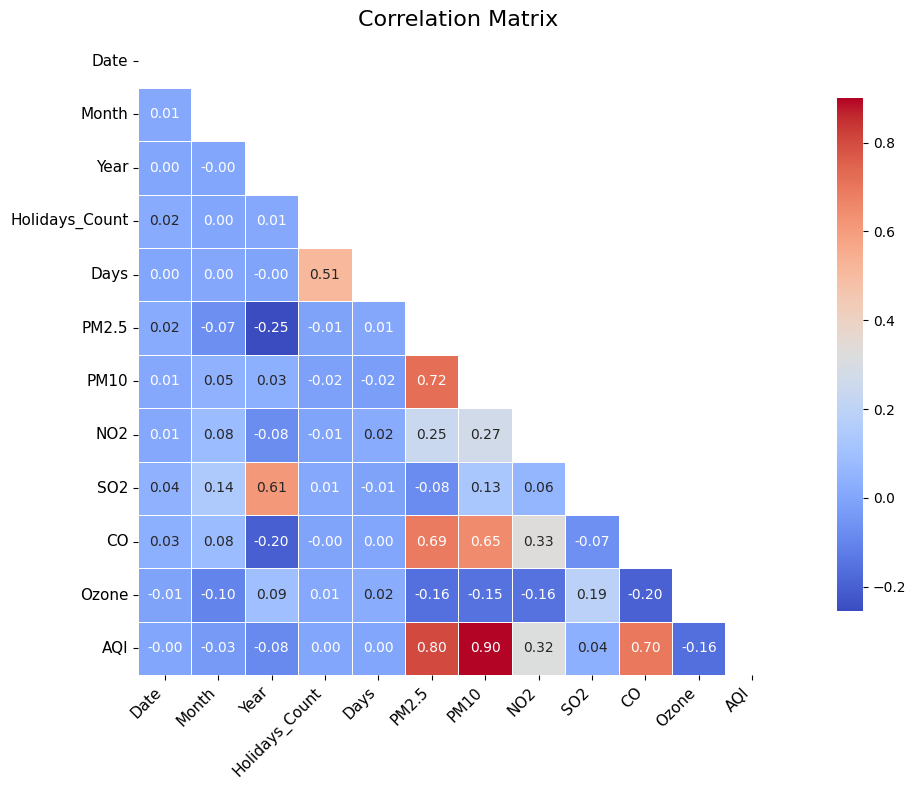

In [528]:
# computing the correlation matrix
corr = df.select_dtypes(include=['number']).corr()

# only lower half (to get rid of unimportant, repeated data)
mask = np.triu(np.ones_like(corr, dtype=bool))

# create map
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})

# formatting
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

The correlation matrix reveals that PM10, PM2.5, and CO have the strongest linear relationships with Delhi’s AQI, while NO₂ shows a weaker, partial correlation. Based on these insights, we select PM10, PM2.5, and CO as our independent variables (predictors) for modeling AQI.

Since AQI is the outcome we aim to predict, it serves as our dependent variable (target). With this setup, we proceed to structure the regression analysis using a standard supervised machine learning approach: splitting the dataset into training and testing subsets to build and evaluate the model.

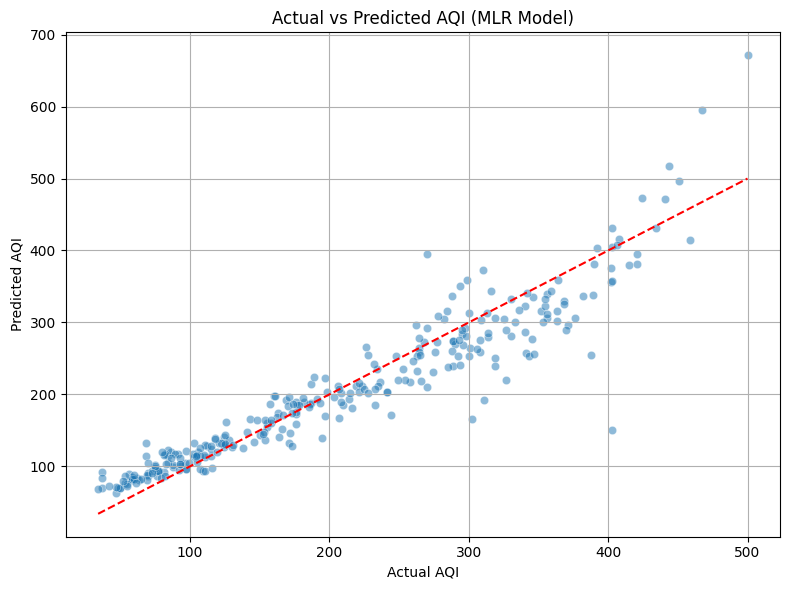

In [529]:
# splitting the dataset into dependent/independent variables
# maybe add NO2 later
X = df[["PM2.5", "PM10", "CO"]]
y = df["AQI"]

# model used (both train and test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fitting MLR model
model = LinearRegression()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# formatting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (MLR Model)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation 
The linear regression model demonstrates a reasonably strong relationship between the selected pollutants (PM2.5, PM10, and CO) and Delhi's AQI. As shown in the plot above, the predicted AQI values generally align well with the actual values, clustering around the ideal 1:1 line. This suggests that the model captures key trends in the data, though some variance and error remain.

Using statsmodels.api, we can calculate an in-depth analysis on the explanatory variables and statistics:

In [530]:
# IMPORTANT: reassign values for statsmodels.api
# printing the full statistical summary

X = df[["PM2.5", "PM10", "CO"]]
X_sm = sm.add_constant(X)
X_sm.columns = ['const', 'PM25', 'PM10', 'CO']

# remaking the test model
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y, test_size=0.2, random_state=42)
model_sm = sm.OLS(y_train_sm, X_train_sm)
results = model_sm.fit()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     2288.
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:02:57   Log-Likelihood:                -5977.8
No. Observations:                1168   AIC:                         1.196e+04
Df Residuals:                    1164   BIC:                         1.198e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2452      2.558     12.214      0.0

interpret F statistic and p-values here

### Fit and Significance
- R-squared = 0.855:

  - Given the R-squared value of 0.855, this means that around 85.5% of the variation in the air quality index in Delhi is explained by the three predictors- PM2.5, PM10, and CO. Thus, these causal factors are a very strong fit for the linear model.

- Adjusted R-squared = 0.855:

    - Since this number is identical to the R² value of 0.855, it suggests the model isn't overfitting and that each included variable contributes meaningfully, making each choice of causal variable valid.


- F-statistic = 2288 and Prob, (F-statistic) = 0.000:


  - This confirms that the model is statistically significant as a whole — at least one of the predictors significantly explains variation in AQI.

#### Additional Note
Because the degree of spread around the line indicates that while the selected variables are strong predictors, other factors not included in this model—such as NO₂, ozone, or temporal features like seasonality—may also contribute to fluctuations in air quality. Nonetheless, the results confirm that PM10, PM2.5, and CO are the dominant predictors of AQI over the observed five-year period.

## Conclusion

In conclusion, it was found that PM10, PM2.5, and CO are the strongest predictors of AQI over the five-year period from 2021 to 2025 using careful linear regression to pinpoint meaningful pollutants that have a significant effect on the air quality of Delhi, India.

In the process, it was found that regression model explained 85.5% of the variation in AQI (R² = 0.855), with all three predictors showing high statistical significance. More specifically, in order of significance, PM10 had the highest explanatory power, followed closely by PM2.5 and CO. The produced model performed well in both interpretability and predictive accuracy, shown by the alignment between actual and predicted values in the Actual vs. Predicted AQI model.

While the model captures the fundamental causal factors of air quality, the residual information from the model suggests that additional variables—such as NO₂, O₃, seasonal effects, or human activity such as holidays, may further improve the model's performance. Given this fact, these ideas might be explored further in the future. Overall, this study demonstrates that even a simple linear model, when built on well-selected features and carefully validated, can offer powerful insight into environmental systems like urban air pollution.